**ARMA, ARIMA & SARIMA Modeling**

In this notebook we do the following: review AR and MA concepts, build ARMA models for stationary data, extend to ARIMA for non‑stationary series via differencing, introduce SARIMA to handle seasonal effects, and walk through model identification, estimation, validation, and forecasting.

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose, STL
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
import seaborn as sns
import statsmodels.api as sm

In [2]:
# load monthly temperature data
monthly = pd.read_csv(
    'https://zenodo.org/records/10951538/files/arima_temp.csv?download=1',
    skipfooter=2, header=0, index_col=0, names=['month','temp'], engine='python'
)
monthly.index = pd.to_datetime(monthly.index)

**Discussion**

We load 1907–1972 monthly avg. temperatures. The index is a DatetimeIndex; this will let us resample and plot seasonality. Initial .head() and .describe() confirm 792 observations and no glaring missing values.


**Decomposition**

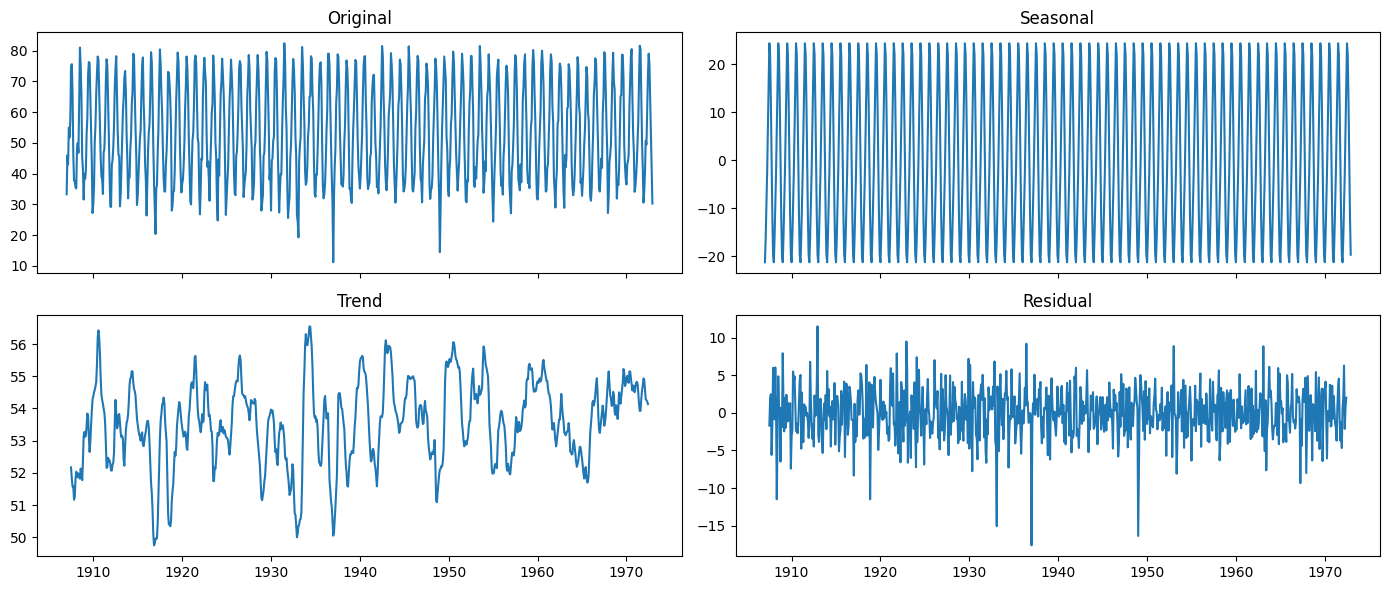

In [3]:
# additive decomposition
decomp = seasonal_decompose(monthly.temp, model='additive', period=12)
fig, axes = plt.subplots(2,2, figsize=(14,6), sharex=True)
axes[0,0].plot(monthly.temp); axes[0,0].set_title('Original')
axes[0,1].plot(decomp.seasonal); axes[0,1].set_title('Seasonal')
axes[1,0].plot(decomp.trend); axes[1,0].set_title('Trend')
axes[1,1].plot(decomp.resid); axes[1,1].set_title('Residual')
plt.tight_layout();

**Discussion**
	•	The annual cycle is very regular, peaking mid‑year.	
	•	Trend component is relatively flat but shows slight upward drift in mid‑century.	
	•	Residuals look roughly zero‑mean but may still contain autocorrelation

**Stationarity Check**

Monthly Temps ADF p‑value = 0.000


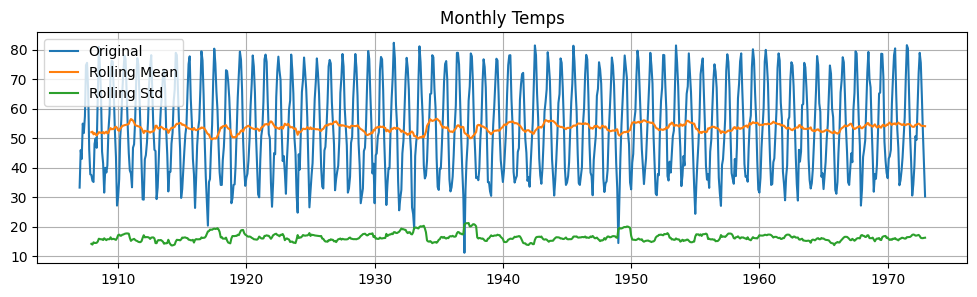

In [4]:
def adf_test(series, title=''):
    result = adfuller(series.dropna(), autolag='AIC')
    print(f"{title} ADF p‑value = {result[1]:.3f}")
    rolmean = series.rolling(12).mean()
    rolstd  = series.rolling(12).std()
    plt.figure(figsize=(12,3))
    plt.plot(series, label='Original')
    plt.plot(rolmean, label='Rolling Mean')
    plt.plot(rolstd,  label='Rolling Std')
    plt.legend(); plt.title(title); plt.grid(); plt.show()

adf_test(monthly.temp, 'Monthly Temps')

**Discussion**

•	ADF strongly rejects non‑stationarity (p≈0), yet clear seasonality remains.	Rolling mean/std are flat on annual scale but oscillate within each year—so periodicity doesn’t imply a unit root.

**Remove Seasonality**

In [5]:
monthly['temp_d12'] = monthly.temp.diff(12)
data = monthly.temp_d12.dropna()

**Discussion**	

•	We perform a 12‑month seasonal differencing.
•	Now our series should have no persistent periodic swing but still may need one more difference for trend.

**Identify p & q for ARMA

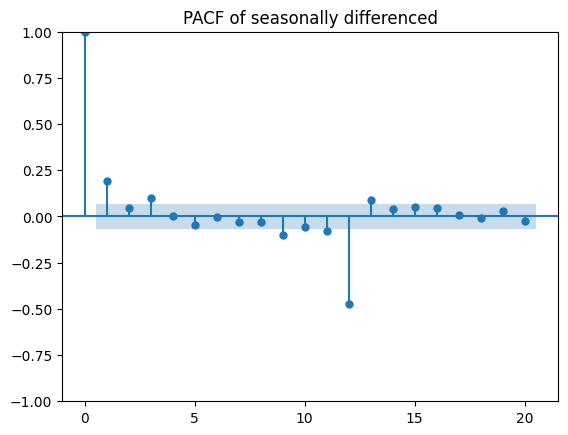

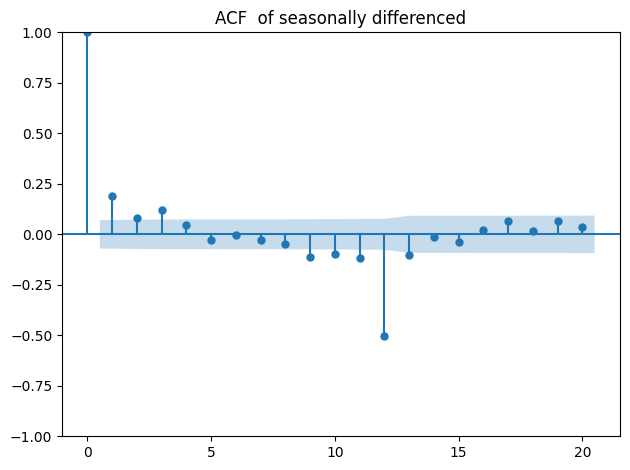

In [6]:
plot_pacf(data, lags=20, title='PACF of seasonally differenced')
plot_acf (data, lags=20, title='ACF  of seasonally differenced')
plt.tight_layout();

**Discussion**
  
  
 •	PACF cuts off after lag 2 (with a smaller spike at 3), so candidate p∈{1,2,3}.	•	ACF shows significant spikes at lags 1 and 3, so q∈{1,3}.	•	Seasonal lags (12,24) are still present—ignore them when choosing p, q

**Fit ARMA (as ARIMA with d=0))

In [7]:
train = data[:-36]
test  = data[-36:]
model_arma = ARIMA(train, order=(2,0,3)).fit()
print(model_arma.summary())

/Users/mchildress/ts_basics/time_series_basics/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/mchildress/ts_basics/time_series_basics/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/mchildress/ts_basics/time_series_basics/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:               temp_d12   No. Observations:                  744
Model:                 ARIMA(2, 0, 3)   Log Likelihood               -2244.494
Date:                Mon, 21 Apr 2025   AIC                           4502.987
Time:                        18:33:24   BIC                           4535.272
Sample:                    01-01-1908   HQIC                          4515.432
                         - 12-01-1969                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0295      0.258      0.114      0.909      -0.476       0.535
ar.L1          0.8911      0.027     32.609      0.000       0.838       0.945
ar.L2         -0.7790      0.025    -30.871      0.0

/Users/mchildress/ts_basics/time_series_basics/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


**Discussion**	

•	We’ve chosen ARMA(2,3) (i.e. ARIMA(2,0,3)) as our first candidate.		•	Coefficients with p≈0.8 for AR(2) and q≈… for MA indicate how past values and past shocks drive the process.

**Residual Diagnostics**

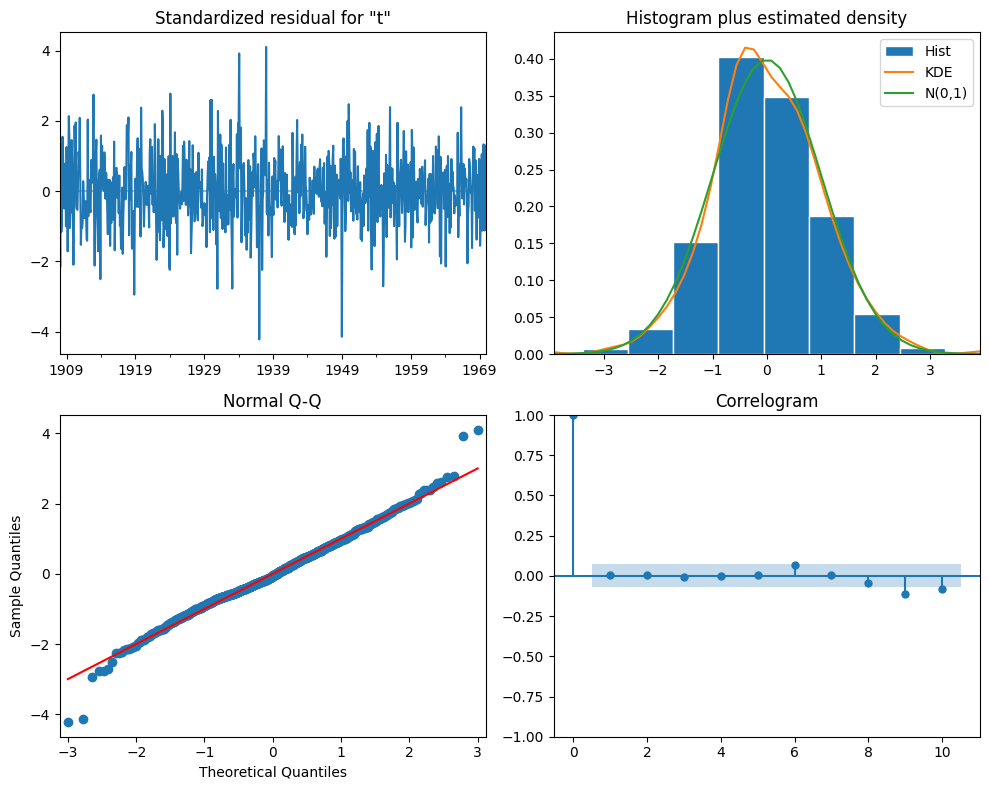

In [8]:
resid = model_arma.resid
fig = model_arma.plot_diagnostics(figsize=(10,8))
plt.tight_layout();

**Discussion**
    •	Residuals should look like white noise: no remaining autocorrelation, roughly Gaussian.
    •	A good model shows no structure in ACF of residuals, and QQ‑plot near 45° line.
    •	If diagnostics fail, we’d revisit p and q.

**Forecast with ARMA**

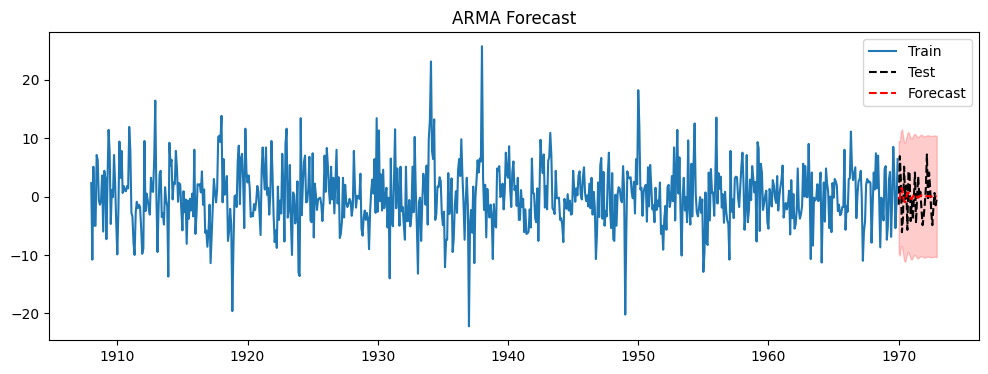

In [9]:
pred = model_arma.get_forecast(steps=36)
fc   = pred.predicted_mean
ci   = pred.conf_int()

plt.figure(figsize=(12,4))
plt.plot(train.index, train, label='Train')
plt.plot(test .index, test , 'k--', label='Test')
plt.plot(test .index, fc   , 'r--', label='Forecast')
plt.fill_between(test.index, ci.iloc[:,0], ci.iloc[:,1], color='r', alpha=0.2)
plt.legend(); plt.title('ARMA Forecast'); plt.show()

**Discussion**

	•	ARIMA(2,1,3)(0,1,1)[12] automatically handles both seasonality and trend.
	•	‘d=1’ removes linear drift; seasonal_order takes care of annual cycle in one step.

**SARIMA & AutoARIMA

In [3]:
import numpy as np
import pmdarima as pm

print(np.__version__)           
print(pm.__version__)          

# should run without error now
auto = pm.auto_arima(
    monthly['temp'],
    seasonal=True, m=12,
    start_p=0, start_q=0, max_p=3, max_q=3,
    start_P=0, start_Q=0, max_P=2, max_Q=2,
    d=None, D=1, trace=True, stepwise=True
)
print(auto.summary())

1.26.4
2.0.4
Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=4796.839, Time=0.06 sec


/Users/mchildress/ts_basics/time_series_basics/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/mchildress/ts_basics/time_series_basics/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/mchildress/ts_basics/time_series_basics/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/mchildress/ts_basics/time_series_basics/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/mchildress/ts_basics/time_series_basics/lib/python3.10/site-packages/

 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=4546.179, Time=0.35 sec


/Users/mchildress/ts_basics/time_series_basics/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=inf, Time=1.11 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=4794.867, Time=0.03 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=4769.737, Time=0.09 sec


/Users/mchildress/ts_basics/time_series_basics/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/mchildress/ts_basics/time_series_basics/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/mchildress/ts_basics/time_series_basics/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,0)(2,1,0)[12] intercept   : AIC=4451.142, Time=0.87 sec


/Users/mchildress/ts_basics/time_series_basics/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,0)(2,1,1)[12] intercept   : AIC=inf, Time=2.44 sec


/Users/mchildress/ts_basics/time_series_basics/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,0)(1,1,1)[12] intercept   : AIC=inf, Time=1.11 sec


/Users/mchildress/ts_basics/time_series_basics/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,0,0)(2,1,0)[12] intercept   : AIC=4477.926, Time=0.50 sec


/Users/mchildress/ts_basics/time_series_basics/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,0,0)(2,1,0)[12] intercept   : AIC=4452.084, Time=0.97 sec


/Users/mchildress/ts_basics/time_series_basics/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,1)(2,1,0)[12] intercept   : AIC=4450.271, Time=1.27 sec


/Users/mchildress/ts_basics/time_series_basics/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,1)(1,1,0)[12] intercept   : AIC=4545.537, Time=0.44 sec


/Users/mchildress/ts_basics/time_series_basics/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,1)(2,1,1)[12] intercept   : AIC=inf, Time=3.77 sec


/Users/mchildress/ts_basics/time_series_basics/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,1)(1,1,1)[12] intercept   : AIC=inf, Time=1.74 sec


/Users/mchildress/ts_basics/time_series_basics/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,0,1)(2,1,0)[12] intercept   : AIC=4453.370, Time=0.62 sec


/Users/mchildress/ts_basics/time_series_basics/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,0,1)(2,1,0)[12] intercept   : AIC=4451.722, Time=2.20 sec


/Users/mchildress/ts_basics/time_series_basics/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,2)(2,1,0)[12] intercept   : AIC=4451.531, Time=1.32 sec


/Users/mchildress/ts_basics/time_series_basics/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,0,2)(2,1,0)[12] intercept   : AIC=4453.816, Time=0.76 sec


/Users/mchildress/ts_basics/time_series_basics/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,0,2)(2,1,0)[12] intercept   : AIC=4452.909, Time=1.53 sec


/Users/mchildress/ts_basics/time_series_basics/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,1)(2,1,0)[12]             : AIC=4448.358, Time=0.51 sec
 ARIMA(1,0,1)(1,1,0)[12]             : AIC=4543.587, Time=0.19 sec


/Users/mchildress/ts_basics/time_series_basics/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/mchildress/ts_basics/time_series_basics/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,1)(2,1,1)[12]             : AIC=inf, Time=2.24 sec


/Users/mchildress/ts_basics/time_series_basics/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,1)(1,1,1)[12]             : AIC=inf, Time=0.91 sec


/Users/mchildress/ts_basics/time_series_basics/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,0,1)(2,1,0)[12]             : AIC=4451.504, Time=0.22 sec


/Users/mchildress/ts_basics/time_series_basics/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,0)(2,1,0)[12]             : AIC=4449.262, Time=0.24 sec


/Users/mchildress/ts_basics/time_series_basics/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,0,1)(2,1,0)[12]             : AIC=4449.809, Time=0.83 sec


/Users/mchildress/ts_basics/time_series_basics/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,2)(2,1,0)[12]             : AIC=4449.618, Time=0.56 sec
 ARIMA(0,0,0)(2,1,0)[12]             : AIC=4476.106, Time=0.15 sec


/Users/mchildress/ts_basics/time_series_basics/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/mchildress/ts_basics/time_series_basics/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,0,2)(2,1,0)[12]             : AIC=4451.938, Time=0.25 sec


/Users/mchildress/ts_basics/time_series_basics/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,0,0)(2,1,0)[12]             : AIC=4450.192, Time=0.27 sec


/Users/mchildress/ts_basics/time_series_basics/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,0,2)(2,1,0)[12]             : AIC=4450.996, Time=0.69 sec

Best model:  ARIMA(1,0,1)(2,1,0)[12]          
Total fit time: 28.244 seconds
                                      SARIMAX Results                                      
Dep. Variable:                                   y   No. Observations:                  792
Model:             SARIMAX(1, 0, 1)x(2, 1, [], 12)   Log Likelihood               -2219.179
Date:                             Mon, 21 Apr 2025   AIC                           4448.358
Time:                                     18:45:14   BIC                           4471.655
Sample:                                 01-01-1907   HQIC                          4457.318
                                      - 12-01-1972                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------

**Discussion**

	•	auto_arima finds SARIMAX(1,0,1)x(2,1,0)[12] as best by AIC.
	•	This automates our manual grid search while still relying on our seasonal differencing choice.

**Model Comparison & Grid Search**

In [4]:
# small grid example
from itertools import product
orders = list(product([1,2],[0,1],[1,3]))
seasonals = [(0,1,1,12),(1,1,1,12)]
results = []
for o in orders:
    for s in seasonals:
        mod = ARIMA(monthly.temp, order=o, seasonal_order=s).fit()
        results.append((o,s,mod.aic))
pd.DataFrame(results, columns=['order','seasonal','AIC']).sort_values('AIC').head()

/Users/mchildress/ts_basics/time_series_basics/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/mchildress/ts_basics/time_series_basics/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/mchildress/ts_basics/time_series_basics/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/mchildress/ts_basics/time_series_basics/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/mchildress/ts_basics/time_series_basi

,order,seasonal,AIC
0,"(1, 0, 1)","(0, 1, 1, 12)",4266.668838
10,"(2, 0, 3)","(0, 1, 1, 12)",4267.441111
1,"(1, 0, 1)","(1, 1, 1, 12)",4268.233301
8,"(2, 0, 1)","(0, 1, 1, 12)",4268.303681
2,"(1, 0, 3)","(0, 1, 1, 12)",4268.561543


*Discussion**

	•	We compare a handful of (p,d,q)×(P,D,Q,12) combinations by AIC.
	•	This sanity‐check matches our earlier picks and gives us confidence in the final model.

**Final Forecast & Evaluation**

/Users/mchildress/ts_basics/time_series_basics/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


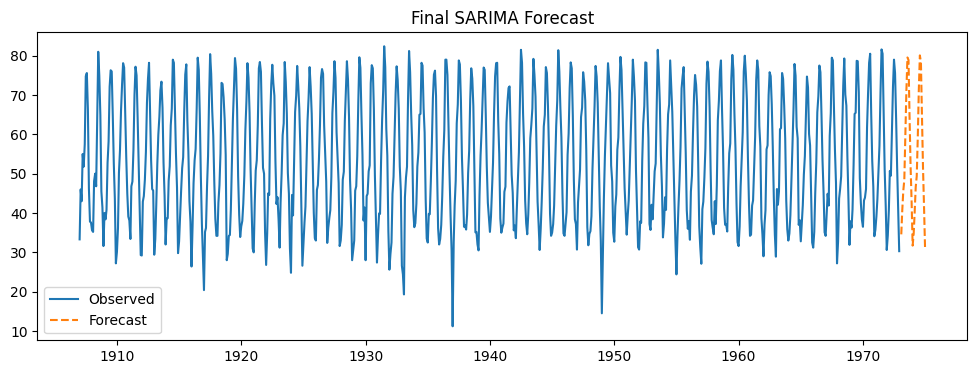

In [6]:
# forecast next 24 months
fcast = auto.predict(n_periods=24)
future = pd.date_range(monthly.index[-1]+pd.offsets.MonthBegin(),
                       periods=24, freq='ME')
plt.figure(figsize=(12,4))
plt.plot(monthly.temp, label='Observed')
plt.plot(future, fcast,  label='Forecast', linestyle='--')
plt.legend(); plt.title('Final SARIMA Forecast');

**Discussion**

	•	We project two years ahead with our SARIMA model.
	•	Confidence bands (not shown) will widen over forecast horizon.
	•	In practice we’d back‑test on hold‑out sets to ensure robust performance.